#Install & Imports

In [1]:
!pip install datasets huggingface_hub regex nltk

from dotenv import load_dotenv
import os
from huggingface_hub import login
from datasets import load_dataset
import pandas as pd
import re
import regex as re2
import nltk
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from collections import Counter
import unicodedata
import numpy as np
import math

#Loading the dataset



In [2]:
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

In [3]:
dataset = load_dataset("KFUPM-JRCAI/arabic-generated-abstracts")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    by_polishing: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2851
    })
    from_title: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2963
    })
    from_title_and_content: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2574
    })
})

In [4]:
# Combine all splits into one dataframe
import pandas as pd

splits = {
    "by_polishing": dataset["by_polishing"],
    "from_title": dataset["from_title"],
    "from_title_and_content": dataset["from_title_and_content"]
}

df_list = []

for split_name, split_data in splits.items():
    temp_df = pd.DataFrame(split_data)

    # Add a column indicating which split this example came from
    temp_df["source_split"] = split_name

    # Create a proper target label column
    # 1 = human-written
    # 0 = AI-generated (we duplicate rows later)
    temp_df["label"] = 1   # original abstract is human

    df_list.append(temp_df)

# Create unified dataframe of human-written abstracts
df_human = pd.concat(df_list, ignore_index=True)

print("Human dataframe shape:", df_human.shape)
df_human.head()

Human dataframe shape: (8388, 7)


,original_abstract,allam_generated_abstract,jais_generated_abstract,llama_generated_abstract,openai_generated_abstract,source_split,label
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,يتناول هذا البحث موضوع التعليم بين النساء الأن...,تدرس هذه الدراسة دور المرأة في التعليم في الأن...,يُقدم هذا البحث دراسة شاملة حول حالة التعليم ع...,صور نظام التعليم عند المرأة الأندلسية تستند إل...,by_polishing,1
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,يتناول هذا البحث دراسة انهيار دولة الموحدين من...,كان العامل الثقافي من بين الأسباب الرئيسية الت...,يعد العامل الثقافي أحد أبرز الأسباب التي يعزى ...,انهيار دولة الموحدين يعود بشكل كبير للعوامل ال...,by_polishing,1
2,شكلت تلك الجهود والمساعي الرائدة التي قام بها ...,هدفت هذه الدراسة إلى تسليط الضوء على جهود قادة...,تدرس هذه الدراسة جهود قادة الثورة الجزائرية خل...,شكلت الجهود التي بذلها قادة الثورة الجزائرية خ...,جهود قادة الثورة الجزائرية خلال المرحلة الأولى...,by_polishing,1
3,يقوم المقال على اشكالية الضرائب الغير شرعية في...,يتناول هذا البحث إشكالية الضرائب غير الشرعية ف...,تدرس المقالة مشكلة الضرائب غير الشرعية في مراح...,يقوم البحث على دراسة الضرائب غير الشرعية في دو...,المقال يناقش قضية الضرائب غير الشرعية في دولتي...,by_polishing,1
4,تتفق المصادر التاريخية المتوفرة حول موضوع تطور...,تتناول هذه الدراسة حركة الانتصار للحريات الديم...,حركة انتصار الحريات الديمقراطية (MTLD)، وهي حر...,تُظهر المصادر التاريخية المتاحة حول تطور الحرك...,حركة انتصار الحريات الديمقراطية (MTLD) في الجز...,by_polishing,1


In [5]:
pip install xlsxwriter

In [ ]:
#Convert AI abstracts to standalone rows

ai_rows = []

for _, row in df_human.iterrows():
    ai_models = [
        ("allam", row["allam_generated_abstract"]),
        ("jais", row["jais_generated_abstract"]),
        ("llama", row["llama_generated_abstract"]),
        ("openai", row["openai_generated_abstract"]),
    ]

    for model_name, text in ai_models:
        ai_rows.append({
            "abstract_text": text,
            "source_split": row["source_split"],
            "generated_by": model_name,
            "label": 0  # AI
        })

# Convert to dataframe
df_ai = pd.DataFrame(ai_rows)

# Create human dataframe in same structure
df_h = pd.DataFrame({
    "abstract_text": df_human["original_abstract"],
    "source_split": df_human["source_split"],
    "generated_by": "human",
    "label": 1
})

# Final unified dataset
df = pd.concat([df_h, df_ai], ignore_index=True)

print("Final unified dataset shape:", df.shape)
df.head(10)

Final unified dataset shape: (41940, 4)


In [7]:
#save the raw data in Excel
output_file = 'original data.xlsx'

df.to_excel(
        output_file,
        index=False,
        engine='xlsxwriter'
    )

#Data Preprocessing

In [8]:
# Preprocessing utilities
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def remove_diacritics(text):
    arabic_diacritics = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    return re.sub(arabic_diacritics, '', text)

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("[^؀-ۿ ]+", " ", text)
    return text

arabic_stopwords = set(stopwords.words("arabic"))
stemmer = ISRIStemmer()

def preprocess_text(text):
    text = str(text)
    text = remove_diacritics(text)
    text = normalize_arabic(text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in arabic_stopwords]
    tokens = [stemmer.stem(w) for w in tokens]
    return " ".join(tokens)

In [10]:
# Apply preprocessing to the  dataset
df["clean_text"] = df["abstract_text"].apply(preprocess_text)

df.head(2)

,abstract_text,source_split,generated_by,label,clean_text
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,by_polishing,human,1,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,by_polishing,human,1,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...


#Feature Engineering

In [ ]:
#TOKENIZATION FUNCTIONS
def simple_word_tokenize(text):
    return re2.findall(r"\p{Arabic}+|\w+|[^\s\w]", text, flags=re2.VERSION1)

def sentence_tokenize(text):
    parts = re.split(r'(?<=[\.\?\!\u061F\u061B])\s+', text)
    return [p.strip() for p in parts if p.strip()]

def paragraph_tokenize(text):
    if not isinstance(text, str):
        return []
    paragraphs = re.split(r'\s*\n\s*\n\s*', text.strip())
    return [p.strip() for p in paragraphs if p.strip()]

In [ ]:
#APPLY TOKEN + SENTENCE EXTRACTION
df["tokens"] = df["clean_text"].apply(lambda t: [tok for tok in simple_word_tokenize(t) if tok.strip()])
df["words"] = df["tokens"].apply(lambda toks: [tok for tok in toks if re.search(r'\w', tok)])
df["sentences"] = df["clean_text"].apply(sentence_tokenize)
df["paragraphs"] = df["clean_text"].apply(paragraph_tokenize)

In [13]:
def safe_div(n, d):
    return n / d if d not in (0, None) else 0.0

In [14]:
def safe_list(x):
    return x if isinstance(x, list) else []

In [15]:
def safe_str(t):
    return t if isinstance(t, str) else ""

In [16]:
df["tokens_raw"] = df["abstract_text"].apply(lambda t: simple_word_tokenize(safe_str(t)))
df["tokens_clean"] = df["clean_text"].apply(lambda t: simple_word_tokenize(safe_str(t)))

df["words_raw"] = df["tokens_raw"].apply(lambda toks: [w for w in toks if re.search(r'\w', w)])
df["words_clean"] = df["tokens_clean"].apply(lambda toks: [w for w in toks if re.search(r'\w', w)])

df["sentences_raw"] = df["abstract_text"].apply(sentence_tokenize)
df["sentences_clean"] = df["clean_text"].apply(sentence_tokenize)

#crating the required features

In [ ]:
# F3 — Digits / Characters
def ratio_digits_over_chars(t):
    t = safe_str(t)
    digits = len(re.findall(r"\d", t))
    chars  = len(t)
    return digits / chars if chars > 0 else 0.0

df["f003_digits_over_C_raw"] = df["abstract_text"].apply(ratio_digits_over_chars)


In [ ]:

#feature 26:Number of Commas
comma_pattern = re.compile(r"[،,]")

def count_commas(t):
    t = safe_str(t)
    return len(comma_pattern.findall(t))

df["f026_commas_raw"] = df["abstract_text"].apply(count_commas)


In [19]:
df.head(5)

,abstract_text,source_split,generated_by,label,clean_text,tokens,words,sentences,paragraphs,tokens_raw,tokens_clean,words_raw,words_clean,sentences_raw,sentences_clean,f003_digits_over_C_raw,f026_commas_raw
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,by_polishing,human,1,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...,"[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...",[ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس ح...,[ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس ح...,"[كثيرا, ما, ارتبطت, المصادر, التاريخية, في, ال...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...","[كثيرا, ما, ارتبطت, المصادر, التاريخية, في, ال...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...",[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,[ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس ح...,0.000000,5
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,by_polishing,human,1,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...,"[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...",[يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي...,[يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي...,"[يعد, العامل, الثقافي, احد, ابرز, الاسباب, الت...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...","[يعد, العامل, الثقافي, احد, ابرز, الاسباب, الت...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...",[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,[يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي...,0.000000,5
2,شكلت تلك الجهود والمساعي الرائدة التي قام بها ...,by_polishing,human,1,شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر مو...,"[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...","[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...",[شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر م...,[شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر م...,"[شكلت, تلك, الجهود, والمساعي, الرائدة, التي, ق...","[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...","[شكلت, تلك, الجهود, والمساعي, الرائدة, التي, ق...","[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...",[شكلت تلك الجهود والمساعي الرائدة التي قام بها...,[شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر م...,0.009016,9
3,يقوم المقال على اشكالية الضرائب الغير شرعية في...,by_polishing,human,1,يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط و...,"[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...","[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...",[يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط ...,[يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط ...,"[يقوم, المقال, على, اشكالية, الضرائب, الغير, ش...","[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...","[يقوم, المقال, على, اشكالية, الضرائب, الغير, ش...","[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...",[يقوم المقال على اشكالية الضرائب الغير شرعية ف...,[يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط ...,0.000000,6
4,تتفق المصادر التاريخية المتوفرة حول موضوع تطور...,by_polishing,human,1,تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي ...,"[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...","[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...",[تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي...,[تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي...,"[تتفق, المصادر, التاريخية, المتوفرة, حول, موضو...","[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...","[تتفق, المصادر, التاريخية, المتوفرة, حول, موضو...","[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...",[تتفق المصادر التاريخية المتوفرة حول موضوع تطو...,[تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي...,0.022837,4


In [20]:
#feature 49 :Number of Arabic Particles
arabic_particles = {
    'من','إلى','عن','على','في','ب','ك','ل',
    'و','أو','ثم','بل','لكن',
    'لا','لم','لن','ما',
    'هل','إن','إذا','أين','متى','كيف','كم','أيان',
    'قد','لمّا','حتى','أن','إنّ','إذن'
}

def count_particles(words):
    words = safe_list(words)
    return sum(1 for w in words if w in arabic_particles)

df["f049_particles_raw"] = df["words_raw"].apply(count_particles)


In [21]:
#Feature 72 : Count of Third-Person Pronouns
third_person_pronouns = {
    "هو","هي","هم","هما","هن",
    "ذلك","تلك","ذلكم","ذلكما","تلكم"
}

def count_pronouns(words):
    words = safe_list(words)
    return sum(1 for w in words if w in third_person_pronouns)

df["f072_third_person_raw"] = df["words_raw"].apply(count_pronouns)


In [22]:
#Feature 95 :Polarity Shift Frequency
pos_words = ["جيد","مفيد","تحسين","إيجابي","نجاح","فعالية"]
neg_words = ["سيء","ضعيف","سلبي","فشل","خسارة","مشكلة"]

def polarity_of(sentence):
    s = safe_str(sentence)
    score = 0
    if any(w in s for w in pos_words): score += 1
    if any(w in s for w in neg_words): score -= 1
    return 1 if score > 0 else -1 if score < 0 else 0

def polarity_shift(sentences):
    S = safe_list(sentences)
    if len(S) < 2:
        return 0
    P = [polarity_of(s) for s in S]
    return sum(1 for a, b in zip(P[:-1], P[1:]) if a != b)

df["f095_shift_clean"] = df["sentences_clean"].apply(polarity_shift)


In [23]:
df.head(5)

,abstract_text,source_split,generated_by,label,clean_text,tokens,words,sentences,paragraphs,tokens_raw,tokens_clean,words_raw,words_clean,sentences_raw,sentences_clean,f003_digits_over_C_raw,f026_commas_raw,f049_particles_raw,f072_third_person_raw,f095_shift_clean
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,by_polishing,human,1,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...,"[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...",[ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس ح...,[ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس ح...,"[كثيرا, ما, ارتبطت, المصادر, التاريخية, في, ال...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...","[كثيرا, ما, ارتبطت, المصادر, التاريخية, في, ال...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...",[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,[ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس ح...,0.000000,5,16,0,0
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,by_polishing,human,1,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...,"[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...",[يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي...,[يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي...,"[يعد, العامل, الثقافي, احد, ابرز, الاسباب, الت...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...","[يعد, العامل, الثقافي, احد, ابرز, الاسباب, الت...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...",[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,[يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي...,0.000000,5,24,0,0
2,شكلت تلك الجهود والمساعي الرائدة التي قام بها ...,by_polishing,human,1,شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر مو...,"[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...","[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...",[شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر م...,[شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر م...,"[شكلت, تلك, الجهود, والمساعي, الرائدة, التي, ق...","[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...","[شكلت, تلك, الجهود, والمساعي, الرائدة, التي, ق...","[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...",[شكلت تلك الجهود والمساعي الرائدة التي قام بها...,[شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر م...,0.009016,9,23,1,0
3,يقوم المقال على اشكالية الضرائب الغير شرعية في...,by_polishing,human,1,يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط و...,"[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...","[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...",[يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط ...,[يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط ...,"[يقوم, المقال, على, اشكالية, الضرائب, الغير, ش...","[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...","[يقوم, المقال, على, اشكالية, الضرائب, الغير, ش...","[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...",[يقوم المقال على اشكالية الضرائب الغير شرعية ف...,[يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط ...,0.000000,6,19,0,0
4,تتفق المصادر التاريخية المتوفرة حول موضوع تطور...,by_polishing,human,1,تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي ...,"[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...","[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...",[تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي...,[تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي...,"[تتفق, المصادر, التاريخية, المتوفرة, حول, موضو...","[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...","[تتفق, المصادر, التاريخية, المتوفرة, حول, موضو...","[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...",[تتفق المصادر التاريخية المتوفرة حول موضوع تطو...,[تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي...,0.022837,4,16,1,0


In [24]:
#save the clean data in Excel
output_file = 'clean data.xlsx'

df.to_excel(
        output_file,
        index=False,
        engine='xlsxwriter'
    )

#Spliting Data

In [25]:
from sklearn.model_selection import train_test_split

# First split: Train 70%, Temp 30%
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, shuffle=True)

# Second split: Temp 30% → 15% Validation, 15% Test
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, shuffle=True)

# Show sizes
print("TOTAL:", len(df))
print("TRAIN:", len(train_df))
print("VAL:", len(val_df))
print("TEST:", len(test_df))

TOTAL: 41940
TRAIN: 29358
VAL: 6291
TEST: 6291


#TF-IDF Features from Cleaned Text



In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer for Arabic text
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,   # limit vocabulary
    ngram_range=(1,2),   # unigrams + bigrams
    analyzer='word'
)

# Fit only on training set
tfidf_vectorizer.fit(train_df["clean_text"])

# Transform train/validation/test sets
X_train_tfidf = tfidf_vectorizer.transform(train_df["clean_text"])
X_val_tfidf   = tfidf_vectorizer.transform(val_df["clean_text"])
X_test_tfidf  = tfidf_vectorizer.transform(test_df["clean_text"])

print("TF-IDF shapes:")
print("Train:", X_train_tfidf.shape)
print("Validation:", X_val_tfidf.shape)
print("Test:", X_test_tfidf.shape)

TF-IDF shapes:
Train: (29358, 5000)
Validation: (6291, 5000)
Test: (6291, 5000)


In [32]:
feature_cols = [
    "f003_digits_over_C_raw",
    "f026_commas_raw",
    "f049_particles_raw",
    "f072_third_person_raw",
    "f095_shift_clean"
]

In [29]:
print(df.columns)


Index(['abstract_text', 'source_split', 'generated_by', 'label', 'clean_text',
       'tokens', 'words', 'sentences', 'paragraphs', 'tokens_raw',
       'tokens_clean', 'words_raw', 'words_clean', 'sentences_raw',
       'sentences_clean', 'f003_digits_over_C_raw', 'f026_commas_raw',
       'f049_particles_raw', 'f072_third_person_raw', 'f095_shift_clean'],
      dtype='object')


In [33]:
train_features = train_df[feature_cols]
val_features   = val_df[feature_cols]
test_features  = test_df[feature_cols]

#Define X and y

In [35]:
from scipy.sparse import hstack


In [36]:
# Target variable
y_train = train_df["label"]
y_val   = val_df["label"]
y_test  = test_df["label"]

# Features: TF-IDF from clean_text
X_train = hstack([X_train_tfidf, train_features])
X_val   = hstack([X_val_tfidf, val_features])
X_test  = hstack([X_test_tfidf, test_features])

print("X and y are ready for ML models.")
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

X and y are ready for ML models.
Train: (29358, 5005) (29358,)
Validation: (6291, 5005) (6291,)
Test: (6291, 5005) (6291,)


#Task 4.1 — Baseline Model  — Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train on training set
lr_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = lr_model.predict(X_val)

# Evaluate on validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.9623271340009537

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4977
           1       0.94      0.87      0.91      1314

    accuracy                           0.96      6291
   macro avg       0.95      0.93      0.94      6291
weighted avg       0.96      0.96      0.96      6291



Test Accuracy: 0.9639167064059768

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4978
           1       0.94      0.89      0.91      1313

    accuracy                           0.96      6291
   macro avg       0.95      0.94      0.94      6291
weighted avg       0.96      0.96      0.96      6291



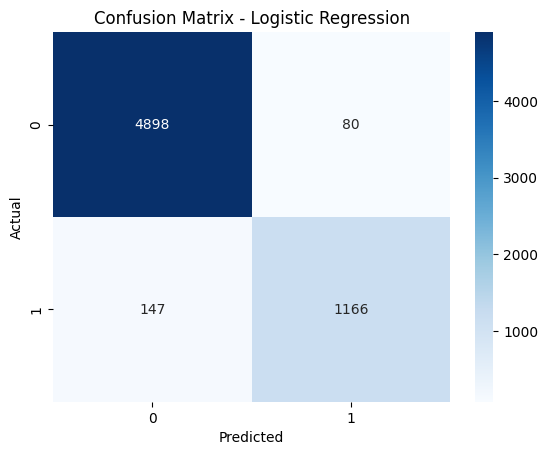

In [38]:
# Evaluation
# Predict on test set
y_test_pred = lr_model.predict(X_test)

# Evaluate on test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Optional: confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

#Task 4.2: Traditional ML Models




In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Dictionary to store models and results
models = {}

# -----------------------
#Support Vector Machine (SVM)
# -----------------------
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

y_val_pred_svm = svm_model.predict(X_val)
print("SVM Validation Accuracy:", accuracy_score(y_val, y_val_pred_svm))
print(classification_report(y_val, y_val_pred_svm))

models['SVM'] = svm_model


#XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_val_pred_xgb = xgb_model.predict(X_val)
print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print(classification_report(y_val, y_val_pred_xgb))

models['XGBoost'] = xgb_model

In [ ]:
#Evaluation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# List of models to evaluate
model_names = ['SVM',  'XGBoost']

for name in model_names:
    model = models[name]

    # Predict on test set
    y_test_pred = model.predict(X_test)

    print(f"\n===== {name} Test Evaluation =====")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#Task 4.3 — Deep Learning Models

##Feedforward Neural Network on Top of BERT Embeddings

###Step1: Extract BERT Embeddings (Sentence-level)

In [ ]:
!pip install sentence-transformers



####We use sentence-transformers because it produces powerful text embeddings and is excellent for classification.

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load Arabic-compatible BERT model
bert_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Convert clean_text into embeddings
X_train_emb = bert_model.encode(train_df["clean_text"].tolist(), convert_to_numpy=True)
X_val_emb   = bert_model.encode(val_df["clean_text"].tolist(), convert_to_numpy=True)
X_test_emb  = bert_model.encode(test_df["clean_text"].tolist(), convert_to_numpy=True)

y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values

print("Train embedding shape:", X_train_emb.shape)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Train embedding shape: (29358, 384)


###Step 2: Build a Feedforward Neural Network

In [ ]:
#import tensorflow as tf
from tensorflow.keras import layers, models

# Basic feedforward classifier on embeddings
ffnn_model = models.Sequential([
    layers.Input(shape=(X_train_emb.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")   # binary classification
])

ffnn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

ffnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,585 (514.00 KB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

###Step3: Train the Model

In [ ]:
history = ffnn_model.fit(
    X_train_emb, y_train,
    validation_data=(X_val_emb, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8033 - loss: 0.4413 - val_accuracy: 0.8034 - val_loss: 0.4032
Epoch 2/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8300 - loss: 0.3741 - val_accuracy: 0.8398 - val_loss: 0.3619
Epoch 3/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8455 - loss: 0.3491 - val_accuracy: 0.8339 - val_loss: 0.3540
Epoch 4/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8460 - loss: 0.3370 - val_accuracy: 0.8460 - val_loss: 0.3366
Epoch 5/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8492 - loss: 0.3326 - val_accuracy: 0.8425 - val_loss: 0.3376
Epoch 6/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8560 - loss: 0.3194 - val_accuracy: 0.8515 - val_loss: 0.3296
Epoch 7/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8590 - loss: 0.3117 - val_accuracy: 0.8453 - val_loss: 0.3203
Epoch 8/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8570 - loss: 0.3089 - val_accuracy:

###Step 4: Evaluate on Test Set

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict
y_test_pred = (ffnn_model.predict(X_test_emb) > 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.8723573358766492
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4978
           1       0.76      0.57      0.65      1313

    accuracy                           0.87      6291
   macro avg       0.83      0.76      0.79      6291
weighted avg       0.87      0.87      0.87      6291



In [ ]:
#Save models
